In [1]:
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os

In [5]:
# units and conversions
Msun = 1.9891e33 # g
Rsun = 69.6e9 #cm
AU = 1.49598e13 #cm
yr = 3.14e7 #seconds
cmtokm = 10**(-5) #converts cm to km
R_mu = 36149835 # (R/mu) for 2.4 g/mol in PPD
Gconv = 6.6743e-8 # cgs
S0conv = (Msun/(AU**2)) #S0cgs = S0code*S0conv
sigsb = 5.67e-5 #Stefan Boltzmann constant
c = 3e10 # speed of light

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)
rc('mathtext', fontset = 'stix')

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
BIGGEST_SIZE = 16

rc('font', size=SMALL_SIZE)          # controls default text sizes
rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGEST_SIZE) 

In [14]:
from scipy.interpolate import griddata

In [373]:
colors = cm.get_cmap('plasma',10)
plkw={'lw':'2','color':'black'}
plkw2 = {'lw':1,'color':'gray','ls':'dashed'}
plkw3 = {'lw':1.5}
plsty = {'base':plkw,'ann':plkw2,'line':plkw3}

In [73]:
stellar_params = {'Ms': 1, 'Rs': 1, 'Ts': 5000}
disk_params = {'Mdisk': 0.03, 'Mfrac': [0.01,0.01],'R0':[1,1], 'Rout':[200,200], 'H0':[0.05,0.025], 'p':[-1,-1], 'fi':[0.25,0.25], 'Rdisk':[60,60]}
envelope_params = {'Min': 1.0e-7, 'Rc':100, 'rho_amb':1e-30, 'rho_0': 1e-20,'theta_min': 10,'exf':0.25,'Rmax':5e5, 'd2g': 0.01 }
grid_params = {'N':[400,360,360], 'min':[0.1,1e-2,0], 'max':[200,pi/2.,2*pi]}

In [55]:
class model:
    def __init__(self,stellar_params, disk_params, envelope_params,grid_params):
        self.star = stellar_params
        self.disk = disk_params
        self.env = envelope_params
        self.grid = grid_params
        self.r = np.linspace(self.grid['min'][0], self.grid['max'][0], self.grid['N'][0])
        self.theta = np.linspace(self.grid['min'][1], self.grid['max'][1], self.grid['N'][1])
        self.phi = np.linspace(self.grid['min'][2], self.grid['max'][2], self.grid['N'][2])
        
    def T(self,R):
        return self.star['Ts']*np.sqrt((self.star['Rs']*Rsun)/(R*AU))
    
    def cs(self,R):
        return 5862*np.sqrt(self.T(1))*(R**(-0.25))
    
    def vk(self,R):
        return sqrt((Gconv*self.star['Ms']*Msun)/(R*AU))
    
    def H(self,R,fluid=0):
        if fluid == 0:
            return self.cs(R)*R/(self.vk(R))
        else:
            return self.disk['H0'][fluid-1]*(R/self.disk['R0'][fluid-1])**(1+self.disk['fi'][fluid-1])
        
    def make_grid(self):
        return np.meshgrid(self.r,self.theta,self.phi)
    
    def make_rz(self):
        R,THETA,PHI = self.make_grid()
        R_CYL = np.clip(R*np.sin(THETA),a_min=1e-5,a_max=None)
        Z_CYL = R*np.cos(THETA)
        return R_CYL, Z_CYL
    
    def sig_profile(self,R,fluid=0): #fluid = 0 for gas, 1 for small dust (follows gas), 2 for large dust (settled)
        def sig_p(R,i=0):
            return (R/self.disk['R0'][i])**(self.disk['p'][i])*np.exp(-R/self.disk['Rdisk'][i])
        def sig_i(R,i=0):
            return -self.disk['Rdisk'][i]*np.exp(-R/self.disk['Rdisk'][i])
        sig_0 = (self.disk['Mdisk']*Msun)/(2*pi*(sig_i(self.disk['Rout'][0])-sig_i(self.disk['R0'][0]))*AU**2)
        sig_ =  sig_0*sig_p(R)
        if fluid == 0: #if gas
            return sig_*[1.0-self.disk['Mfrac'][0]-self.disk['Mfrac'][1]]
        if fluid == 1: #if small_dust
            return sig_*self.disk['Mfrac'][0]
        if fluid == 2: # if large_dust
            sig_0 = (self.disk['Mdisk']*Msun*self.disk['Mfrac'][1])/(2*pi*(sig_i(self.disk['Rout'][1])-sig_i(self.disk['R0'][1]))*AU**2)
            return sig_0*sig_p(R,1)
    
    def rho_midplane(self,R,fluid=0):
        return self.sig_profile(R,fluid=fluid)/(sqrt(pi*2.)*self.H(R,fluid=fluid)*AU)
    
    def rho_disk(self,fluid=0):
        R_CYL,Z_CYL = self.make_rz()
        rho_mid = self.rho_midplane(R_CYL,fluid=fluid)
        h_mid = self.H(R_CYL,fluid=fluid)
        rho_vol = rho_mid*np.exp(-0.5*(Z_CYL/h_mid)**2)
        return rho_vol
    
    def plot_slice(self,rho,plot_params={'levels':np.arange(-27,-11,1)}):
        R_CYL,Z_CYL = self.make_rz()
        contourf(R_CYL[:,:,0],Z_CYL[:,:,0], np.log10(rho[:,:,0]),**plot_params)
        colorbar()
        
    def rho_stream(self, th0=pi/2.):
        th = self.theta[self.theta>=th0]
        Rc = self.env['Rc']
        Min = self.env['Min']
        if th0 != pi/2. and th0 != 0.:
            r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))
            r[0] = self.env['Rmax']
            r[-1] = Rc*(np.sin(th0)**2)
        elif th0 <= 1e-5:
            r = np.ones_like(th)*1
        else:
            r= np.ones_like(th)*Rc
        om = np.sqrt(Gconv*self.star['Ms']*Msun*(r*AU)**3)
        t1 = (Min*Msun/yr)/(8*pi*om)
        t2 = np.sqrt(1+(np.cos(th)/np.cos(th0)))
        t3 = ((np.cos(th)/(2*np.cos(th0))) + (Rc/r)*(np.cos(th0)**2))
        rho1 = t1/(t2*t3)
        return r, th, rho1
    
    
    def rho_env(self,fluid=0):
        thstart = np.radians(self.env['theta_min'])
        rho0 = self.env['rho_0']
        R = np.array([])
        TH = np.array([])
        rho_tot = np.array([])
        for j in self.theta:
            r, th, rho1 = self.rho_stream(th0=j)
            R = np.append(R,r)
            TH = np.append(TH,th)
            if j <= thstart:
                rho_tot = np.append(rho_tot,rho1*0+rho0*r**(-self.env['exf']))
            else:
                rho_tot = np.append(rho_tot,rho1)
        # define grid.
        R_CYL = R*np.sin(TH)
        Z_CYL = R*np.cos(TH)
        r_cyl, z_cyl = self.make_rz()
        RHO = griddata((R_CYL, Z_CYL), rho_tot, (r_cyl[:,:,0],z_cyl[:,:,0]), method='nearest')
        RHO = np.reshape(RHO,(np.shape(RHO)[0],np.shape(RHO)[1],1))
        rho_vol = np.repeat(RHO,len(self.phi),axis=2)
        if fluid == 0:
            return rho_vol
        else:
            return rho_vol*self.env['d2g']
        
    
    def rho_embedded(self,fluid=0):
        rho_d = self.rho_disk(fluid=fluid)
        if fluid < 2:
            rho_e = self.rho_env(fluid=fluid)
        else:
            rho_e = np.zeros_like(rho_d)
        floor = self.env['rho_amb'] 
        factor = min(fluid,1)*self.env['d2g']
        if factor != 0: 
            floor *= factor
        if fluid < 2:
            rho_both = np.clip(rho_d + rho_e,a_min=floor,a_max=None)
        else:
            rho_both = rho_d + rho_e
        return rho_both
    
    
    def write_grid(self):
        iformat = 1
        grid_style = 0 # for "regular grid"
        coordsystem = 101 # between 1 and 200 for a spherical grid
        gridinfo = 0 
        incl_x, incl_y, incl_z = [1,1,1] # for a 3 dimensional grid
        nx,ny,nz = self.grid['N']
        dr = np.diff(self.r)[0]
        dth = np.diff(self.theta)[0]
        dphi = np.diff(self.phi)[0]
        r_edges = np.linspace(self.grid['min'][0], self.grid['max'][0], self.grid['N'][0] + 1)*AU
        th_edges = np.linspace(self.grid['min'][1], self.grid['max'][1], self.grid['N'][1] + 1)
        phi_edges = np.linspace(self.grid['min'][2], self.grid['max'][2], self.grid['N'][2] + 1)
        header = str(iformat) + '\n' + str(grid_style) + '\n' + str(coordsystem) + '\n' + str(gridinfo) + '\n' + str(incl_x) + '\t' + str(incl_y) + '\t' + str(incl_z) + '\n' + str(nx) + '\t' + str(ny) + '\t' + str(nz) + '\n'
        #np.savetxt("amr_grid.inp",np.reshape(r_edges*AU,(1,nx+1)),header=header,comments='',fmt='%13.6e',delimiter='\t',newline='')
        with open("amr_grid.inp","w") as f:
            f.write(header)
            for x,fmt  in zip([r_edges,th_edges,phi_edges],['%13.6e','%17.10e','%13.6e']):
                x.tofile(f, sep= '\t', format=fmt)
                f.write('\n')
        f.close()

    
    def write_dust_density(self):
        small_dust = self.rho_embedded(fluid=1)
        large_dust = self.rho_embedded(fluid=2)
        Nr = np.prod(np.array(self.grid['N']))
        with open('dust_density.inp','w+') as f:
            f.write('1\n')                   # Format number
            f.write('%d\n'%(Nr))           # Number of cells
            f.write('2\n')                   # Number of dust species
            for dust in [small_dust,large_dust]:
                data = dust.ravel(order='F')         # Create a 1-D view, fortran-style indexing
                data.tofile(f, sep='\n', format="%13.6e")
                f.write('\n')
        f.close()
    
    

    
    

In [41]:
# Write the wavelength_micron.inp file
#
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size
#
# Write the wavelength file
#
with open('wavelength_micron.inp','w+') as f:
    f.write('%d\n'%(nlam))
    for value in lam:
        f.write('%13.6e\n'%(value))

        
with open('dustopac.inp','w+') as f:
    f.write('2               Format number of this file\n')
    f.write('2               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('0.1_micron      Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('100_micron      Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')
    
    
nphot    = 1000000

mstar    = Msun
rstar    = 6.696e10
tstar    = 50000
pstar    = np.array([0.,0.,0.])


with open('stars.inp','w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n'%(nlam))
    f.write('%13.6e %13.6e %17.10e %17.10e %17.10e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
    for value in lam:
        f.write('%13.6e\n'%(value))
    f.write('\n%13.6e\n'%(-tstar))
    
with open('radmc3d.inp','w+') as f:
    f.write('nphot = %d\n'%(nphot))
    f.write('scattering_mode_max = 0\n')   # Put this to 1 for isotropic scattering
    f.write('iranfreqmode = 1\n')

In [49]:
d = rpy.analyze.readData(ddens=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


In [56]:
d1 = model(stellar_params, disk_params, envelope_params,grid_params)
d1.write_grid()
d1.write_dust_density()

<ipython-input-55-ab28a06e35f0>:70: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))


Reading image.out


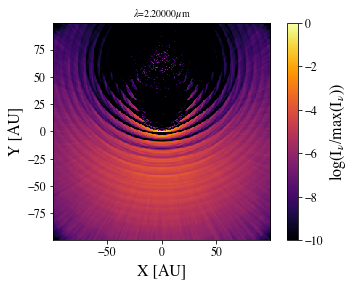

{'implot': <matplotlib.image.AxesImage at 0x7fb57651a700>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fb5767ef8e0>}

In [70]:
#rpy.image.makeImage(npix=300., wav=2.2, incl=20., phi=0., sizeau=200.)
im = rpy.image.readImage()
rpy.image.plotImage(im, au=True, log=True, maxlog=10, saturate=1, cmap=cm.inferno)

<ipython-input-55-ab28a06e35f0>:70: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))


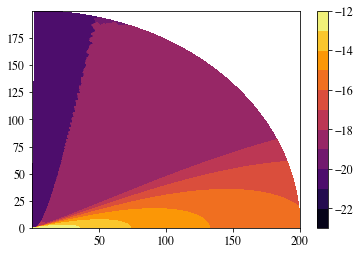

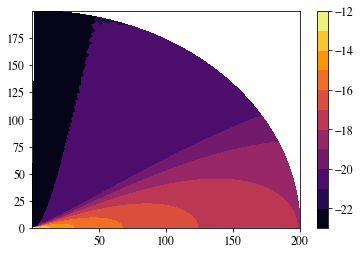

<ipython-input-55-ab28a06e35f0>:62: RuntimeWarning: divide by zero encountered in log10
  contourf(R_CYL[:,:,0],Z_CYL[:,:,0], np.log10(rho[:,:,0]),**plot_params)


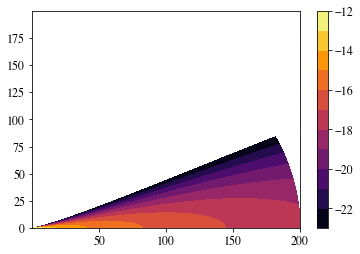

In [74]:
d1 = model(stellar_params, disk_params, envelope_params,grid_params)

d1.plot_slice(d1.rho_embedded(fluid=0),plot_params ={'levels': np.arange(-23,-11,1),'cmap':'inferno'})
show()
d1.plot_slice(d1.rho_embedded(fluid=1),plot_params ={'levels': np.arange(-23,-11,1),'cmap':'inferno'})
show()
d1.plot_slice(d1.rho_embedded(fluid=2),plot_params ={'levels': np.arange(-23,-11,1),'cmap':'inferno'})
show()